# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error, classification_report

pd.set_option('display.max_columns', None)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Cleaning

1. Clean the portfolio dataset
    - Create dummy columns for each channel
    - Create dummy columns for each offer
    - Remove the original channels & offer_type columns
    - Rename the id column to offer_id in case of confusion with customer_id

In [2]:
def clean_portfolio(portfolio):
    """
    Clean portfolio dataset: 
    - create dummy columns for each channel
    - create dummy columns for each offer type
    - remove the original channels & offer_type columns
    - rename the id column to offer_id in case of confusion with customer_id
    Input:
    - portfolio: original portfolio dataset
    Output:
    - portfolio_clean
    """
    # create dummy column for each channel
    channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack(),prefix="channel").sum(level=0)
    # create dummy column for each offer type
    offer_type = pd.get_dummies(portfolio['offer_type'],prefix="offer_type")
    # combine the dummy channels and dummy offer types with the original dataset and remove the original channels & offer_type columns
    portfolio_clean = pd.concat([portfolio, channels, offer_type], axis=1, sort=False)
    portfolio_clean.drop(columns=['channels', 'offer_type'], inplace=True)
    # rename the id column to offer_id
    portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)
    return portfolio_clean

In [3]:
# save the cleaned portfolio dataset to portfolio_clean
portfolio_clean = clean_portfolio(portfolio)
portfolio_clean.head()

,difficulty,duration,offer_id,reward,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


2. Clean the profile dataset
    - Change the format of became_member_on column to date
    - Create a column to separate vailid and invalid age data
    - Change the id column to customer_id in case of confusion with offer_id
    - Create dummy columns for gender
    - remove original gender column and became_member_on column

In [4]:
def clean_profile(profile):
    """
    Clean profile dataset: 
    - fix the format of became_member_on column
    - remove rows with invalid age data (age = 118)
    - change the id column to customer_id in case of confusion with offer_id
    - create dummy columns for gender
    - remove original gender column and became_member_on column
    Input:
    - profile: original profile dataset
    Output:
    - profile_clean
    """
    profile_clean = profile.copy()
    # fix the format of became_member_on column
    profile_clean.became_member_on = profile_clean.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    # remove rows with invalid age data (age = 118)
    profile_clean = profile_clean[profile_clean.age != 118]
    # Change the id column to customer_id
    profile_clean.rename(columns={'id':'customer_id'}, inplace=True)
    # Create dummy columns for different gender
    gender = pd.get_dummies(profile_clean.gender, prefix="gender")
    # combine the dummy columns for gender with the dataset and remove the original gender column
    profile_clean = pd.concat([profile_clean, gender], axis=1, sort=False)
    # create new member_tenure column
    profile_clean['member_tenure'] = (datetime.today().date() - profile_clean['became_member_on'].dt.date).dt.days
    # remove original gender column and became_member_on column
    profile_clean.drop(columns=['gender','became_member_on'], inplace=True)
    return profile_clean

In [5]:
# save the cleaned profile dataset to profile_clean
profile_clean = clean_profile(profile)
profile_clean.head()

,age,customer_id,income,gender_F,gender_M,gender_O,member_tenure
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1400
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1467
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,1115
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,1191
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,1281


3. Clean the transcript dataset
    - replace the space in event with _ then create dummy columns for each event
    - extract offer id from the value column
    - drop the value column after extraction
    - rename the person column to customer_id

In [6]:
def clean_transcript(transcript):
    """
    Clean transcript dataset:
    - replace the space in event with _ then create dummy columns for each event
    - extract offer id from the value column
    - drop the value column after extraction
    - rename the person column to customer_id
    Input:
    - transcript: original transcript dataset
    Output:
    - transcript_clean
    """
    # replace the space in event with _ then create dummy columns for each event
    transcript.event = transcript.event.str.replace(' ', '_')
    event = pd.get_dummies(transcript.event, prefix="event")
    # combine the event dummy columns with the original transcript dataset and drop the original event column
    transcript_clean = pd.concat([transcript, event], axis=1, sort=False)
    transcript_clean.drop(columns='event', inplace=True)
    # extract offer id from the value column
    transcript_clean['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id', 'offer_id'] 
                                    else None
                                    for v in transcript_clean.value]
    # extract transaction amount from the value column
    transcript_clean['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' 
                                  else None
                                  for v in transcript_clean.value]
    # drop the value column after extraction
    transcript_clean.drop(columns='value', inplace=True)
    # rename the person column to customer_id
    transcript_clean.rename(columns={'person':'customer_id'}, inplace=True)
    return transcript_clean

In [7]:
# save the cleaned transcript dataset to transcript_clean
transcript_clean = clean_transcript(transcript)
transcript_clean.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# Analysis

## 1. How many customers received offers in this dataset? What kind of offers did they recieve?

In [8]:
# Count how many unique customers received at least 1 offer
customer_offer_received = transcript_clean[transcript_clean.event_offer_received == 1]['customer_id'].nunique()
print("{} customers received at least 1 offer.".format(customer_offer_received))

16994 customers received at least 1 offer.


In [9]:
# create a function to get a new column for offer type
def offer_type(row):
    if row['offer_type_bogo'] == 1:
        return "bogo"
    elif row['offer_type_discount'] == 1:
        return "discount"
    elif row['offer_type_informational'] == 1:
        return "informational"

In [10]:
# merge transcript_clean & portfolio_clean dataset to get offer_type data
transcript_df = pd.merge(transcript_clean, portfolio_clean, on='offer_id', how='left')
transcript_df['offer_type'] = transcript_df.apply(lambda row: offer_type(row), axis=1)
transcript_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,20.0,10.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,discount
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,7.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,10.0,10.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,discount
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,5.0,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,bogo


In [11]:
# Get the breakdown of offer type
offer_breakdown = transcript_df[transcript_df.event_offer_received == 1].groupby(['offer_type','offer_id'])['customer_id'].nunique()
offer_breakdown = offer_breakdown.reset_index()
offer_breakdown.rename(columns={'customer_id':'count'}, inplace=True)
offer_breakdown

,offer_type,offer_id,count
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,6330
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,6355
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,6374
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,6262
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,6374
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6325
6,discount,2906b810c7d4411798c6938adc9daaa5,6285
7,discount,fafdcd668e3743c1bb461111dcafc2a4,6332
8,informational,3f207df678b143eea3cee63160fa8bed,6331
9,informational,5a8bc65990b245e5a138643cd4eb9837,6320


Text(0.5,0.98,'Breakdown of different offers customers received')

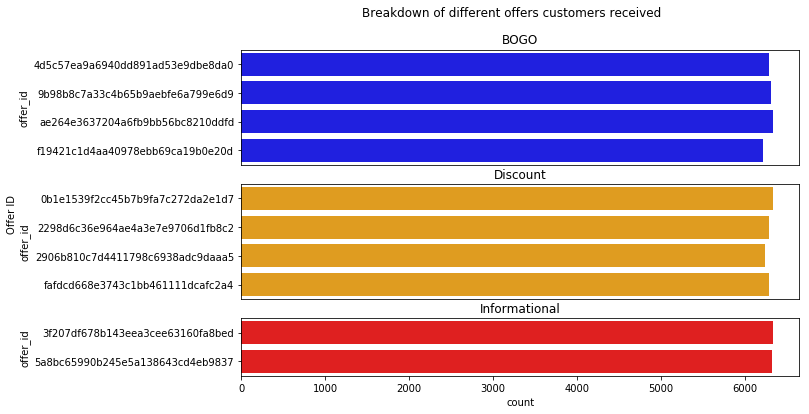

In [12]:
# visualize the breakdown of different offers
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 2, 1]}, figsize=(10,6))
sns.barplot(y = 'offer_id', x='count', data=offer_breakdown[offer_breakdown.offer_type == 'bogo'], color="b", ax = ax1)
sns.barplot(y = 'offer_id', x='count', data=offer_breakdown[offer_breakdown.offer_type == 'discount'], color="orange", ax = ax2)
sns.barplot(y = 'offer_id', x='count', data=offer_breakdown[offer_breakdown.offer_type == 'informational'], color="red", ax = ax3)
ax1.title.set_text('BOGO')
ax2.title.set_text('Discount')
ax3.title.set_text('Informational')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

fig.text(-0.2, 0.5, 'Offer ID', va='center', rotation='vertical')
fig.suptitle('Breakdown of different offers customers received')

Text(0.5,1,'Distribution of unique offers customers receive')

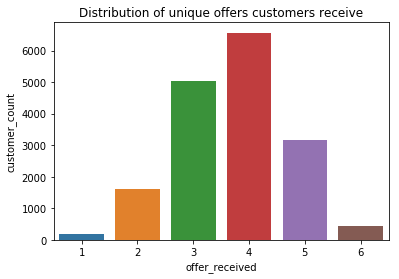

In [13]:
offer_received_per_customer = transcript_df[transcript_df.event_offer_received == 1].groupby("customer_id")['offer_id'].nunique().reset_index()
offer_received_per_customer.rename(columns={'offer_id':'offer_received'}, inplace=True)
customer_offer_count = offer_received_per_customer.groupby('offer_received')['customer_id'].nunique().reset_index()
customer_offer_count.rename(columns={'customer_id':'customer_count'}, inplace=True)
ax = sns.barplot(x = 'offer_received', y = 'customer_count', data=customer_offer_count)
ax.set_title('Distribution of unique offers customers receive')

Based on the analysis, we are able to get some general idea of the offers customers received:
1. 16,994 unique customers received at least 1 offer.
2. Customers received 10 different types of offers, 4 are BOGO offers, 4 are discount offers, 2 are informational offers.
3. The unique customer size that received each offers are similar, around 6,500.
4. The majority of the customers received 3-5 diffent kinds of offers, while there are some customers received only 1-2 kinds of offers or 6 kinds of offers.

## 2. Customer Analysis: What do the customers look like (age, gender, income, etc.)? 
### Income Dsitribution

In [14]:
# get descrptive data of the income destribution
profile_clean.describe()['income']

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

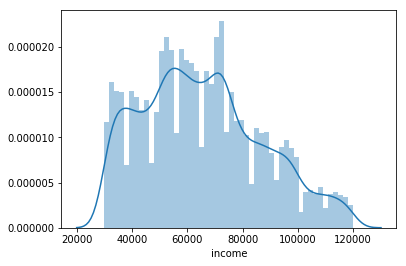

In [15]:
# draw the distribution of the customers income
sns.distplot(profile_clean[~profile_clean['income'].isnull()]['income'], bins=50)

- The average income if the customers is \\$65,404 , while the median is \\$64,000
- The distribution of income is slightly right skewed

### Age and Gender Dsitribution

In [16]:
# copy the profile_clean dataset to do analysis
profile_df = profile_clean.copy()

In [17]:
# get descrptive data of the age destribution after removing the invalid ages
profile_df.describe()['age']

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

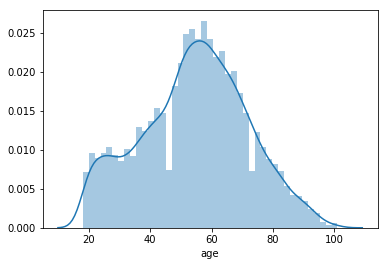

In [18]:
# remove the invalid data and redraw the histogram
sns.distplot(profile_df['age'])

In [19]:
# create gender function to create a new gender column
def gender(row):
    if row['gender_F'] == 1:
        return "Female"
    elif row['gender_M'] == 1:
        return "Male"

# create age_group function to put customer with differnt age into age groups
def age_group(row):
    if row['age'] <= 24:
        return "18-24"
    elif row['age'] <= 34:
        return "25-34"
    elif row['age'] <= 44:
        return "35-44"
    elif row['age'] <= 54:
        return "45-54"
    elif row['age'] <= 64:
        return "55-64"
    elif row['age'] <= 74:
        return "65-74"
    elif row['age'] > 74:
        return "75+"

In [20]:
# create new columns using the function
profile_df['gender'] = profile_df.apply(lambda row: gender(row), axis=1)
profile_df['age_group'] = profile_df.apply(lambda row: age_group(row), axis=1)

In [21]:
# remove rows with invalid age and gender
profile_df = profile_df[~(profile_df['gender'].isnull())]

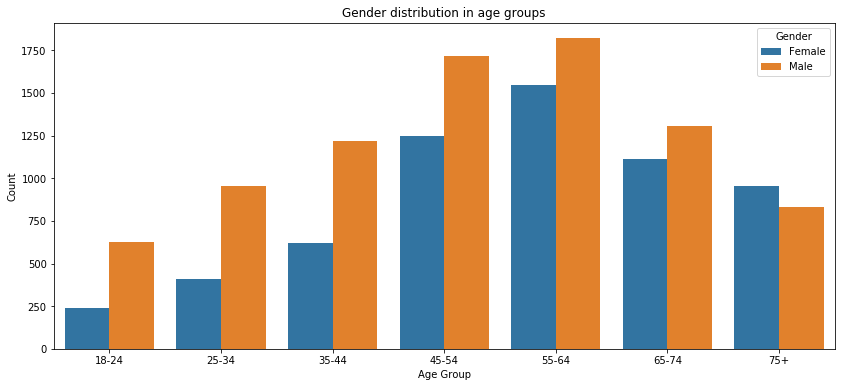

In [22]:
# visualize the distribution of gender and age
fig, ax  = plt.subplots(1, 1, figsize=(14,6))
ax = sns.countplot(x='age_group', data = profile_df, order=['18-24','25-34','35-44','45-54','55-64','65-74','75+'], hue='gender')
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

- The distribution of age is close to normal with the mean of 54.39 and median of 55.
- The percentage of male customers is higher than female in all age groups except the 75+ group.
- The biggest age group is 55-65, the second biggest group is 45-54. The smallest age group is 18-24.

## 3. Offer Analysis: How effective are the offers? What kind of offer are more effective to drive order?

In [23]:
# Clean the transcript_df to remove the rows with no offer_id
offer_df = transcript_df[~transcript_df['offer_id'].isnull()][['customer_id','event_offer_completed','event_offer_received','event_offer_viewed','offer_id','offer_type']]
offer_df.head()


,customer_id,event_offer_completed,event_offer_received,event_offer_viewed,offer_id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,e2127556f4f64592b11af22de27a7932,0,1,0,2906b810c7d4411798c6938adc9daaa5,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,discount
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo


In [24]:
offer_agg_df = offer_df.groupby(['offer_type','offer_id']).sum().reset_index()
offer_agg_df = offer_agg_df[['offer_type','offer_id','event_offer_received','event_offer_viewed','event_offer_completed']]
offer_agg_df

,offer_type,offer_id,event_offer_received,event_offer_viewed,event_offer_completed
0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,7593.0,7298.0,3331.0
1,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677.0,4171.0,4354.0
2,bogo,ae264e3637204a6fb9bb56bc8210ddfd,7658.0,6716.0,3688.0
3,bogo,f19421c1d4aa40978ebb69ca19b0e20d,7571.0,7264.0,4296.0
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668.0,2663.0,3420.0
5,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,7646.0,7337.0,5156.0
6,discount,2906b810c7d4411798c6938adc9daaa5,7632.0,4118.0,4017.0
7,discount,fafdcd668e3743c1bb461111dcafc2a4,7597.0,7327.0,5317.0
8,informational,3f207df678b143eea3cee63160fa8bed,7617.0,4144.0,0.0
9,informational,5a8bc65990b245e5a138643cd4eb9837,7618.0,6687.0,0.0


Text(0.5,0.98,'Breakdown of the effectiveness of each offer')

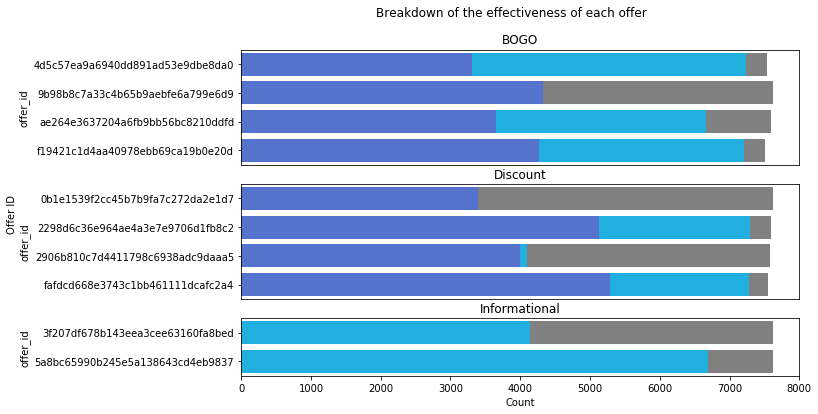

In [25]:
# Visualize the effitiveness of different offers
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 2, 1]}, figsize=(10,6))
sns.barplot(y='offer_id',x='event_offer_received', data=offer_agg_df[offer_agg_df.offer_type == 'bogo'], color='grey', ax=ax1)
sns.barplot(y='offer_id',x='event_offer_viewed', data=offer_agg_df[offer_agg_df.offer_type == 'bogo'], color='deepskyblue',ax=ax1)
sns.barplot(y='offer_id',x='event_offer_completed', data=offer_agg_df[offer_agg_df.offer_type == 'bogo'], color='royalblue',ax=ax1)
sns.barplot(y='offer_id',x='event_offer_received', data=offer_agg_df[offer_agg_df.offer_type == 'discount'], color='grey', ax=ax2)
sns.barplot(y='offer_id',x='event_offer_viewed', data=offer_agg_df[offer_agg_df.offer_type == 'discount'], color='deepskyblue',ax=ax2)
sns.barplot(y='offer_id',x='event_offer_completed', data=offer_agg_df[offer_agg_df.offer_type == 'discount'], color='royalblue',ax=ax2)
sns.barplot(y='offer_id',x='event_offer_received', data=offer_agg_df[offer_agg_df.offer_type == 'informational'], color='grey', ax=ax3)
sns.barplot(y='offer_id',x='event_offer_viewed', data=offer_agg_df[offer_agg_df.offer_type == 'informational'], color='deepskyblue',ax=ax3)
sns.barplot(y='offer_id',x='event_offer_completed', data=offer_agg_df[offer_agg_df.offer_type == 'informational'], color='royalblue',ax=ax3)
ax1.title.set_text('BOGO')
ax2.title.set_text('Discount')
ax3.title.set_text('Informational')
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.set_xlabel("Count")

fig.text(-0.2, 0.5, 'Offer ID', va='center', rotation='vertical')
fig.suptitle('Breakdown of the effectiveness of each offer')


By looking at the breakdown of different kinds of offers, we can find:
- Informational offer is different from other types of offers, it doesn't drive orders directly
- On average discount offers have higher convertion rate (offer_completed/offer_received) than bogo offers.
- There're one bogo offer and one discount offer both have higher offer used than offer views, which might worth deep investigation.

# Merge the three cleaned datasets and prepare data for model training

In [26]:
def merge_dataset(portfolio_clean, profile_clean, transcript_clean):
    """
    Merge and process the cleaned dataset before model training:
    - create offer_usuage dataset for customers who've received the offer and the time when they received the first offer with the same offer_id
    - create transaction dataset for customer_id, time, and amount
    - merge offer_usuage and transaction to get the transaction amount *before* the offer sent
    - merge the datasets
    - drop customer_id and offer_id column
    Input:
    - portfolio_clean: cleaned portfolio dataset
    - profile_clean: cleaned profile dataset
    - transcript_clean: cleaned transcript dataset
    Output:
    - merge_df
    """
    # create offer_usuage dataset for customers who've received the offer and the time when they received the first offer with the same offer_id
    offer_usuage = transcript_clean.groupby(['customer_id','offer_id']).agg({'time': np.min,
                                                          'event_offer_received': np.max,
                                                          'event_offer_viewed': np.max,
                                                          'event_offer_completed': np.max
                                                          }).reset_index()
    # create transaction dataset for customer_id, time, and amount
    transaction = transcript_clean[transcript_clean['event_transaction'] == 1][['customer_id', 'time', 'amount']]
    # merge offer_usuage and transaction to get the transaction amount *before* the offer sent
    merge_df = pd.merge(offer_usuage, transaction, on='customer_id', how='left')
    merge_df = merge_df[merge_df['time_x'] > merge_df['time_y']].groupby(['customer_id','offer_id']).agg({'event_offer_viewed': np.max,
                                                                                          'event_offer_completed':np.max,
                                                                                          'amount': np.sum
                                                                                          }).reset_index()
    # merge the merged dataset with cleaned profile dataset
    merge_df = pd.merge(merge_df, profile_clean, on='customer_id', how="inner")
    # merge the merged dataset with cleaned porfolio dataset
    merge_df = pd.merge(merge_df,  portfolio_clean, on='offer_id', how='inner')
    merge_df.drop(columns=['customer_id', 'offer_id'], inplace=True)
    return merge_df

In [27]:
merge_df = merge_dataset(portfolio_clean, profile_clean, transcript_clean)

merge_df.head()

,event_offer_viewed,event_offer_completed,amount,age,income,gender_F,gender_M,gender_O,member_tenure,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,1,58.40,33,72000.0,0,1,0,1485,10,7,2,1,1,0,1,0,1,0
1,0,0,60.67,19,65000.0,1,0,0,1740,10,7,2,1,1,0,1,0,1,0
2,0,0,9.71,56,47000.0,0,1,0,1253,10,7,2,1,1,0,1,0,1,0
3,1,1,307.30,58,119000.0,1,0,0,1255,10,7,2,1,1,0,1,0,1,0
4,0,0,5.95,24,42000.0,0,1,0,1343,10,7,2,1,1,0,1,0,1,0


In [28]:
# make sure there is no missing data
merge_df.isnull().sum()

event_offer_viewed          0
event_offer_completed       0
amount                      0
age                         0
income                      0
gender_F                    0
gender_M                    0
gender_O                    0
member_tenure               0
difficulty                  0
duration                    0
reward                      0
channel_email               0
channel_mobile              0
channel_social              0
channel_web                 0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

# Build machine learning models to predict the offer usage
## 1. Define features & target and create train and test datasets
First, we defined the features and target

In [29]:
# define features and target
X = merge_df.drop(columns=['event_offer_completed'])
y = merge_df['event_offer_completed']

We then define the function that can split the features and target into training and testing datasets ans scale the featrues using StandardScaler()

In [30]:
def model_pipeline(features, target):
    """
    Split the features and target into training and testing datasets ans scale the featrues using StandardScaler()
    Input:
    - features
    - target
    Output:
    - X_train: training features
    - X_test: testing features
    - y_train: training target
    - y_test: testing target  
    """
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [31]:
#use the function to do train/test split
X_train, X_test, y_train, y_test = model_pipeline(X,y)

## 2. Train Classifier

In [32]:
def fit_clf(model, param_grid, X_train, y_train): 
    """
    Fits a classifier to training data set using grid search and calculates f1_score
    Input:
    - model: classifier to fit
    - param_grid (dict): classifier parameters
    - X_tarin: training featrues
    - y_train: training target
    Output:
    - best_score: best score of grid search
    - best_est: best estimator of grid search
    """
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(model.__class__.__name__))
    grid.fit(X_train, y_train)
    
    print(model.__class__.__name__)
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    best_score = grid.best_score_
    best_est = grid.best_estimator_
    return best_score, best_est

In [33]:
#initialize classifiers
lr = LogisticRegression(random_state = 42) 
rf = RandomForestClassifier(random_state = 42) 
ab = AdaBoostClassifier(random_state = 42) 
gb = GradientBoostingClassifier(random_state = 42) 

In [34]:
# find the best classifier for training data
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for classifier in [lr, rf, ab, gb]:
    best_score, best_est = fit_clf(classifier, {}, X_train, y_train)
    clf_names.append(classifier.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)

Training LogisticRegression :
LogisticRegression
Best f1_score : 0.8296
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Best f1_score : 0.8181
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Best f1_score : 0.8383
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Best f1_score : 0.8477
****************************************


In [36]:
clf_dict['best_f1_score'] = clf_scores
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_f1_score,best_est
LogisticRegression,0.829561,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.818087,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.838320,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.847726,([DecisionTreeRegressor(criterion='friedman_ms...


Based on the f1 scores of the four classifiers, GradientBoostingClassifier is the best classifier algorithm

In [37]:
clf_df.loc['GradientBoostingClassifier', 'best_est']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

## 3. Model Refinement

In [38]:
# tuning GradientBoostingClassifier
param_grid = {
              'n_estimators': [10, 50, 80, 100],
              'max_depth': [3],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'learning_rate': [0.15,0.1,0.05,0.01,0.005,0.001]}
gb = GradientBoostingClassifier(random_state = 42) 
gb_best_score, gb_best_est = fit_clf(gb, param_grid, X_train, y_train)
gb_best_est

Training GradientBoostingClassifier :
GradientBoostingClassifier
Best f1_score : 0.848
****************************************


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

## 4. Feature importance

In [39]:
importance_df  = pd.DataFrame(gb_best_est.feature_importances_, index=X.columns.tolist(),columns=['feature_importance']).reset_index()
importance_df.rename(columns={'index': 'feature'}, inplace=True)
importance_df = importance_df.sort_values(by=['feature_importance'], ascending=False).reset_index(drop=True)
importance_df 

,feature,feature_importance
0,amount,0.219144
1,member_tenure,0.207783
2,income,0.162723
3,reward,0.093946
4,duration,0.071114
5,difficulty,0.059166
6,event_offer_viewed,0.042738
7,age,0.037921
8,offer_type_informational,0.032069
9,gender_M,0.019964


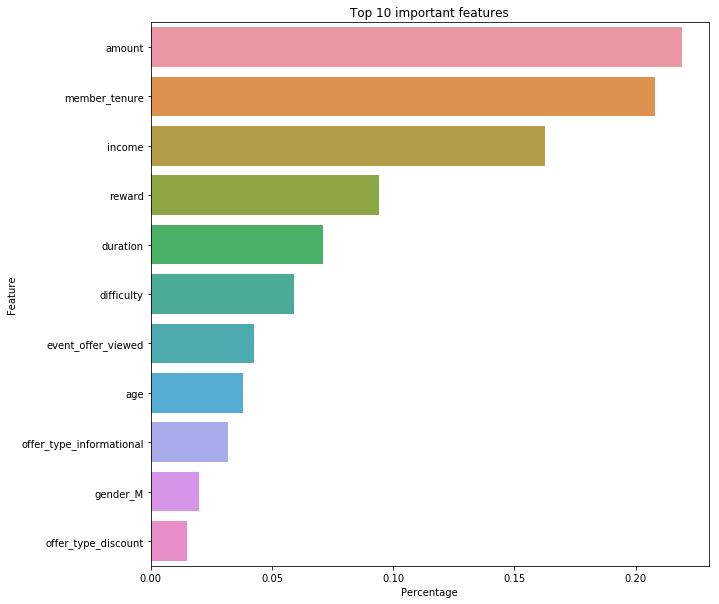

In [40]:
# visualize the top 10 important features
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=importance_df.loc[0:10,'feature_importance'], y=importance_df.loc[0:10,'feature'], data=importance_df)
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.title('Top 10 important features')
plt.show()

From the data and the visualization we can see what are the most important features that impact sucess of the coupon:
-  Amount spent before receiving the coupon is the most imprtant one.
- member tenure, income, rewards level all plays are also very important.
- demographics factors of the customers (like gender, age, income) can impact the success of coupons too.

## 5. Predict test tata and draw confusion matrix

In [41]:
# use the model to predict test data
predictions = gb_best_est.predict(X_test)
predictions

array([0, 0, 1, ..., 1, 0, 1], dtype=uint8)

In [42]:
confusion_matrix(y_test.squeeze().values, predictions)

array([[2745,  840],
       [ 413, 3625]])

In [43]:
def draw_confusion_matrix(y_true, y_pred, classes, normalize=False, title="Confusion Matrix", cmap = plt.cm.Greys):
    """
    print and draw the confusion matrix.
    Input:
    - y_true:
    - y_pred: 
    - classes:
    - normalize: default set to False, but could be changed to True to get normalized confusion matrix
    - title: title of the plot, default set to "Confusion Matrix", but could be changed to other values 
    - cmap: color map
    Output:
    - ax: object of the confusion matrix plot
    """
    # compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # get labels that in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # print confusion matrix
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')
    print(conf_matrix)
    # create plot for confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[2745  840]
 [ 413 3625]]


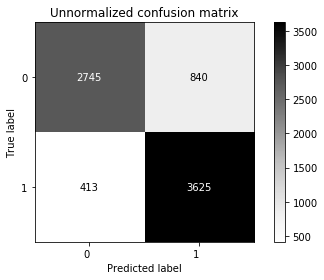

In [44]:
# draw unnormalized confusion matrix
np.set_printoptions(precision=2)
class_names = np.array([0, 1])
draw_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names,title='Unnormalized confusion matrix')

Normalized confusion matrix
[[ 0.77  0.23]
 [ 0.1   0.9 ]]


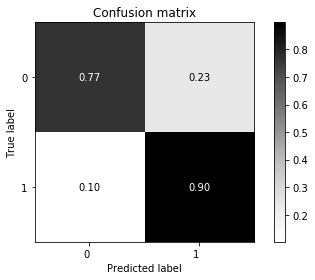

In [45]:
# draw normalized confusion matrix
draw_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names, normalize=True,title='Confusion matrix')

The accuracy of the model is 0.836, precision is 0.812, and recall is 0.898. The model is relatively good since it have lower chance of misclassifying customers who use the offer.

# Conclusion
In this project, we used the three datasets provided trying to build a machine learning model to predict customers who use the offer. The featrues we used include demographics data like income, gender, age, meta data of the offers like rewards, defficult, customer membership and transaction data like membership tenure, amount spent before recieiving the offer, etc. We clean up the data sets first. After exploratory data analysis, we combined the three cleaned datasets into one, split it into training and testing sets. We finally decided to use GradientBoostingClassifier model since it has higher f1 socre. The final model we got has 0.836 accuracy, precision is 0.812, and recall is 0.898.

# Improvements
1. In many cases, data itself is more important than tuning the model. In this case, if we have more data on customers, we are likely to train a better model. For example, one the the most important featrues in the model is amount customers spent before receiving the offer during the test time period. If we can get more historical transcation data, we might be able to build a better model.
2. While offers can drive more sales, they could also result in lower margin, in this project, we are predicing if customers activate the offer. Another possible model we could build is predicting the amount customers will spend when using the offer. If we can build a model like this, we could send offers to customers who are likely to spend more and have higher margins when activating the offer.
3. Some customers will spend either they have offers or not, while some others will less likely to spend if they don't have any other offers. Instead of sending offers to every customers who are likely to spend, we can create different segments and target customers who are less likely to spend when they don't have offers.